In [5]:
import pandas as pd
import seaborn as sns

# %%
df = pd.DataFrame(columns=["Cipher", "Mode", "CPU", "Length", "Speed"])


# %%
def addfile_2(cpu, filename, cipher, dftmp):
    with open(filename, "r", encoding="utf8", errors='ignore') as f:
        lines = f.readlines()
        for line in lines:
            if "---" in line:
                line = line.replace("-", '').replace("(Gbps)", "")
                mode = line.replace("speed test", "").strip()
                if "GCM" in mode:
                    mode = "AEAD"
            elif "length" in line:
                length, speed = line.split(',')[:2]
                length = int(length.split(":")[1])
                speed = float(speed.split(":")[1])
                dftmp = pd.concat([dftmp, pd.DataFrame([[cipher, mode, cpu, length, speed]], columns=dftmp.columns)], ignore_index=True)
    return dftmp

In [6]:
def addfile_3(cpu, filename, dftmp):
    with open(filename, "r", encoding="utf8", errors='ignore') as f:
        lines = f.readlines()
        for i in range(len(lines)):
            if "type" in lines[i] and "bytes" in lines[i]:
                #type           8192 bytes
                length = int(lines[i].split()[1])
                speed = float(lines[i+1].split()[1][:-2]) / 1000 / 1000 * 8
                cipher = lines[i+1].split()[0]
                if "GCM" in cipher:
                    mode = "AEAD"
                else:
                    mode = "Encryption Only"
                dftmp = pd.concat([dftmp, pd.DataFrame([[cipher, mode, cpu, length, speed]], columns=dftmp.columns)], ignore_index=True)
    return dftmp

In [7]:
Devices = ["Apple M1", "Apple M2 Max", "Apple M3 Pro", "AMD EPYC 9334", "Intel Xeon Gold 6326", 
           "Intel Xeon Gold 6230", "Intel Xeon Silver 4108", "Intel Xeon E5-2620 v3", "AMD EPYC 7763"]
Devices_dir = ["M1", "M2Max", "M3Pro", "EPYC9334", "IceLake", "Xeon6230", "Xeon4108", "E5-2620v3", "EPYC7763"]
ciphers = ["HiAE", "ROCCA", "ROCCA-S", "AEGIS", "SNOW-V"]
ciphers_name = ["HiAE", "Rocca", "Rocca-S", "Aegis", "Snow-V"]
for device_id in range(9):
    for id in range(5):
        for i in range(1, 4):
            df = addfile_2(Devices[device_id], f"{Devices_dir[device_id]}/{ciphers[id]}_log_{i}", ciphers_name[id], df)
    for cipher in ["AES-256-GCM", "AES-256-CTR"]:
        for i in range(1, 4):
            df = addfile_3(Devices[device_id], f"{Devices_dir[device_id]}/{cipher}_log_{i}", df)
df

,Cipher,Mode,CPU,Length,Speed
0,HiAE,Encryption Only,Apple M1,16,7.310000
1,HiAE,Encryption Only,Apple M1,64,17.440000
2,HiAE,Encryption Only,Apple M1,256,72.430000
3,HiAE,Encryption Only,Apple M1,512,100.690000
4,HiAE,Encryption Only,Apple M1,1024,126.710000
...,...,...,...,...,...
2803,AES-256-CTR,Encryption Only,AMD EPYC 7763,4096,42.272544
2804,AES-256-CTR,Encryption Only,AMD EPYC 7763,2048,41.270414
2805,AES-256-CTR,Encryption Only,AMD EPYC 7763,1024,38.903728
2806,AES-256-CTR,Encryption Only,AMD EPYC 7763,256,29.750402


In [13]:
df = df[df["Length"] != 16]
df

,Cipher,Mode,CPU,Length,Speed
1,HiAE,Encryption Only,Apple M1,64,17.440000
2,HiAE,Encryption Only,Apple M1,256,72.430000
3,HiAE,Encryption Only,Apple M1,512,100.690000
4,HiAE,Encryption Only,Apple M1,1024,126.710000
5,HiAE,Encryption Only,Apple M1,2048,145.610000
...,...,...,...,...,...
2803,AES-256-CTR,Encryption Only,AMD EPYC 7763,4096,42.272544
2804,AES-256-CTR,Encryption Only,AMD EPYC 7763,2048,41.270414
2805,AES-256-CTR,Encryption Only,AMD EPYC 7763,1024,38.903728
2806,AES-256-CTR,Encryption Only,AMD EPYC 7763,256,29.750402


In [14]:
df.to_csv("logs.csv", index=False)
df_avg = df.groupby(['Cipher', 'Mode', 'CPU', 'Length']).mean().reset_index()
df_avg.to_csv("logs_avg.csv", index=False)
df_avg

,Cipher,Mode,CPU,Length,Speed
0,AES-256-CTR,Encryption Only,AMD EPYC 7763,64,12.159340
1,AES-256-CTR,Encryption Only,AMD EPYC 7763,256,27.405902
2,AES-256-CTR,Encryption Only,AMD EPYC 7763,1024,38.927005
3,AES-256-CTR,Encryption Only,AMD EPYC 7763,2048,41.163708
4,AES-256-CTR,Encryption Only,AMD EPYC 7763,4096,42.414473
...,...,...,...,...,...
841,Snow-V,Encryption Only,Intel Xeon Silver 4108,1024,20.866667
842,Snow-V,Encryption Only,Intel Xeon Silver 4108,2048,24.856667
843,Snow-V,Encryption Only,Intel Xeon Silver 4108,4096,26.083333
844,Snow-V,Encryption Only,Intel Xeon Silver 4108,8192,27.453333


Text(0.5, 1.0, 'Benchmark on AMD EPYC 7763')

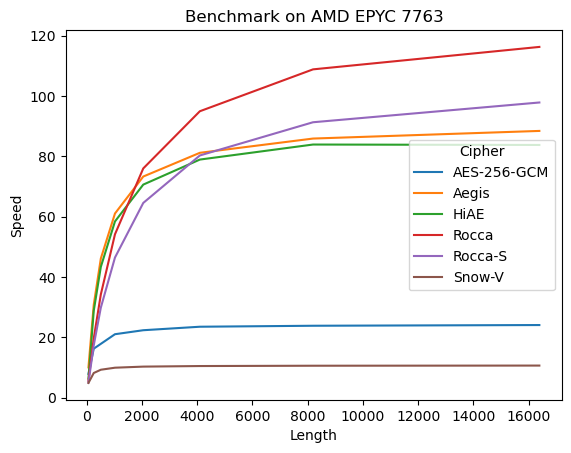

In [33]:
CPU_name = "AMD EPYC 7763"
Mode_name = 'AEAD'
import matplotlib.pyplot as plt
sns.lineplot(data=df_avg[(df_avg['CPU'] == CPU_name) & (df_avg['Mode'] == Mode_name)& (df_avg['Length'] < 17000) & (df_avg['Length'] >=64)], x='Length', y='Speed', hue="Cipher", palette="tab10")
plt.title("Benchmark on " + CPU_name)

In [49]:
Devices = ["Apple M1", "Apple M2 Max", "Apple M3 Pro", "AMD EPYC 9334", "Intel Xeon Gold 6326", 
           "Intel Xeon Gold 6230", "Intel Xeon Silver 4108", "Intel Xeon E5-2620 v3", "AMD EPYC 7763"]
ciphers_name = ["HiAE", "Rocca", "Rocca-S", "Aegis", "Snow-V", "AES-256"]
for device in Devices:
    print("\\multicolumn{16}{|c|}{\\textbf{" + device + "}}\\\\\n\\hline")
    for cipher in ciphers_name:
        s = ""
        for mode in ["Encryption Only", "AEAD"]:
            if cipher == "Snow-V":
                if mode == "AEAD":
                    s += f"& SNOW-V-GCM "
                else:
                    s += f"& SNOW-V "
            elif cipher == "Aegis":
                s += f"& AEGIS-128L "
            elif cipher == "HiAE":
                s += f"& HiAE (this work) "
            elif "AES-256" in cipher:
                if mode == "AEAD":
                    cipher = "AES-256-GCM"
                else:
                    cipher = "AES-256-CTR"
                s += f"& {cipher} "
            else:
                s += f"& {cipher} "
        
            for lens in [16384, 8192, 4096, 2048, 1024, 256, 64]:
                speed_value = df_avg.loc[(df_avg["Cipher"] == cipher) & (df_avg["Mode"] == mode) & (df_avg["Length"] == lens) & (df_avg["CPU"] == device), "Speed"].values
                if len(speed_value) > 0:
                    s += f" & {speed_value[0]:.2f} "
                else:
                    s += " & N/A "
        print(s[1:] + "\\\\")
    print("\\hline")

\multicolumn{16}{|c|}{\textbf{Apple M1}}\\
\hline
 HiAE (this work)  & 163.44  & 157.72  & 152.82  & 141.72  & 124.07  & 70.00  & 16.88 & HiAE (this work)  & 163.16  & 155.23  & 142.88  & 124.87  & 99.30  & 45.25  & 10.69 \\
 Rocca  & 142.27  & 139.28  & 128.66  & 109.00  & 86.05  & 39.81  & 13.58 & Rocca  & 142.93  & 138.61  & 130.80  & 116.91  & 97.35  & 48.54  & 17.08 \\
 Rocca-S  & 119.42  & 115.43  & 108.80  & 95.02  & 75.02  & 35.55  & 12.33 & Rocca-S  & 129.47  & 125.27  & 114.99  & 96.62  & 80.12  & 37.65  & 12.58 \\
 AEGIS-128L  & 102.85  & 98.37  & 98.37  & 91.63  & 76.57  & 43.09  & 15.50 & AEGIS-128L  & 100.47  & 97.28  & 91.55  & 84.88  & 70.01  & 31.69  & 10.30 \\
 SNOW-V  & 26.56  & 26.68  & 25.54  & 24.81  & 23.07  & 15.00  & 7.00 & SNOW-V-GCM  & 10.53  & 10.33  & 10.29  & 10.46  & 10.19  & 9.98  & 8.56 \\
 AES-256-CTR  & 69.34  & 69.48  & 68.21  & 66.83  & 64.44  & 50.09  & 27.72 & AES-256-GCM  & 46.42  & 45.73  & 44.27  & 41.81  & 37.23  & 31.14  & 20.01 \\
\hline
\mu